In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import av
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image

class DrivingDataset(Dataset):
    def __init__(self, csv_file, video_path, transform=None):
        self.data = pd.read_csv(csv_file)
        self.video_path = video_path
        
        # Pre-load all frames into memory
        print("Loading video frames into memory...")
        self.frames = []
        
        # Open video with PyAV
        container = av.open(video_path)
        stream = container.streams.video[0]
        stream.thread_type = "AUTO"  # Enable multithreading
        
        frame_dict = {}  # Temporary dictionary to store frames
        
        # Read all frames first
        for frame_idx, frame in enumerate(container.decode(stream)):
            frame_dict[frame_idx] = frame.to_ndarray(format='rgb24')
            if len(frame_dict) % 100 == 0:  # Progress update
                print(f"Loaded {len(frame_dict)} frames...")
        
        print(f"Total frames in video: {len(frame_dict)}")
        print(f"Frame indices in CSV: {len(self.data)}")
        
        # Now get only the frames we need
        for idx in self.data['frame_idx']:
            if idx in frame_dict:
                # Convert to PIL Image and resize
                frame = Image.fromarray(frame_dict[idx])
                frame = frame.resize((200, 66), Image.Resampling.BILINEAR)
                # Convert back to numpy array
                frame = np.array(frame)
                self.frames.append(frame)
            else:
                print(f"Warning: Frame {idx} not found in video. Total frames: {len(frame_dict)}")
                # Use the closest available frame as a fallback
                closest_idx = min(frame_dict.keys(), key=lambda x: abs(x - idx))
                frame = Image.fromarray(frame_dict[closest_idx])
                frame = frame.resize((200, 66), Image.Resampling.BILINEAR)
                frame = np.array(frame)
                self.frames.append(frame)
                
        container.close()
        print(f"Successfully loaded {len(self.frames)} frames")
        
        # Define default transforms if none provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                  std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        frame = self.frames[idx]
        steering_angle = self.data.iloc[idx]['steering_angle']
        
        if self.transform:
            frame = self.transform(frame)
            
        return frame, steering_angle

In [3]:
import torch
import torch.nn as nn

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting steering angles from dashcam images.
    Based on NVIDIA's PilotNet architecture with some simplifications.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Layer 1: 24 filters of 5x5, stride 2
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            # Layer 2: 36 filters of 5x5, stride 2
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            
            # Layer 3: 48 filters of 5x5, stride 2
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            
            # Layer 4: 64 filters of 3x3, stride 1
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Layer 5: 64 filters of 3x3, stride 1
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1152, 100),  # Will be updated by _calculate_conv_output_size
            nn.BatchNorm1d(100),
            nn.ReLU(),
            
            nn.Dropout(0.3),    
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            
            nn.Linear(50, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            
            nn.Linear(10, 1),
            nn.Tanh(),  # Outputs between -1 and +1
            Lambda(lambda x: x * 45)  # Scale to ±45 degrees
        )
        
        # Calculate the flattened size
        self._calculate_conv_output_size()
        
    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        # Create a dummy input tensor (batch_size, channels, height, width)
        # Assuming input images will be resized to 66x200
        x = torch.zeros(1, 3, 66, 200)
        x = self.conv_layers(x)
        
        # Get the flattened size
        flattened_size = x.numel() // x.size(0)
        
        # Update the first fully connected layer's input size
        self.fc_layers[1] = nn.Linear(flattened_size, 100)
        
        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened features size: {flattened_size}")
        
    def forward(self, x):
        """Forward pass through the network"""
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [4]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Training on {device}")
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, angles in train_loader:
            inputs = inputs.to(device)
            angles = angles.to(device).float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, angles)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        
        with torch.no_grad():
            for inputs, angles in val_loader:
                inputs = inputs.to(device)
                angles = angles.to(device).float().view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, angles)
                running_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}')
    
    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curves.png')
    plt.show()
    
    return model, train_losses, val_losses

In [5]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, angles in test_loader:
            inputs = inputs.to(device)
            angles = angles.to(device).float().view(-1, 1)
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(angles.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Calculate metrics
    mse = np.mean((all_preds - all_targets)**2)
    mae = np.mean(np.abs(all_preds - all_targets))
    
    # Calculate percentage of predictions within different degree thresholds
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100
    
    print("\nTest Results:")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")
    
    # Visualize predictions vs ground truth
    plt.figure(figsize=(15, 5))
    
    # Plot sample predictions
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Ground Truth')
    plt.plot(all_preds[:100], label='Predictions')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    
    # Plot correlation
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-20, 20], [-20, 20], 'r--')  # Perfect prediction line
    plt.xlabel('Ground Truth (degrees)')
    plt.ylabel('Prediction (degrees)')
    plt.title('Prediction Correlation')
    
    plt.tight_layout()
    plt.savefig('test_results.png')
    plt.show()

Loading video frames into memory...
Loaded 100 frames...
Loaded 200 frames...
Loaded 300 frames...
Loaded 400 frames...
Loaded 500 frames...
Loaded 600 frames...
Loaded 700 frames...
Loaded 800 frames...
Loaded 900 frames...
Loaded 1000 frames...
Loaded 1100 frames...
Total frames in video: 1197
Frame indices in CSV: 1197
Successfully loaded 1197 frames
Dataset sizes: Train=837, Val=179, Test=181
Calculated convolutional output size: torch.Size([1, 64, 1, 18])
Flattened features size: 1152

Starting training...
Training on cpu
Epoch 1/50: Train Loss: 171.2311, Val Loss: 27.3149
Epoch 2/50: Train Loss: 43.1336, Val Loss: 18.0531
Epoch 3/50: Train Loss: 24.9182, Val Loss: 5.2774
Epoch 4/50: Train Loss: 20.0682, Val Loss: 8.8564
Epoch 5/50: Train Loss: 21.4858, Val Loss: 8.0653
Epoch 6/50: Train Loss: 15.3172, Val Loss: 8.0195
Epoch 7/50: Train Loss: 13.6372, Val Loss: 6.0310
Early stopping triggered at epoch 8


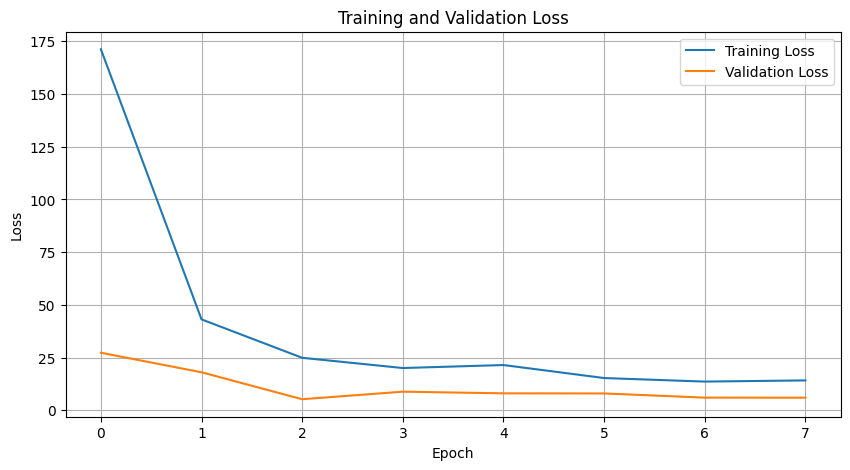


Model saved to 'steering_model.pth'

Testing the model...

Test Results:
MSE: 4.6773 degrees²
MAE: 1.5212 degrees
Predictions within 1°: 51.9%
Predictions within 3°: 86.7%
Predictions within 5°: 96.7%


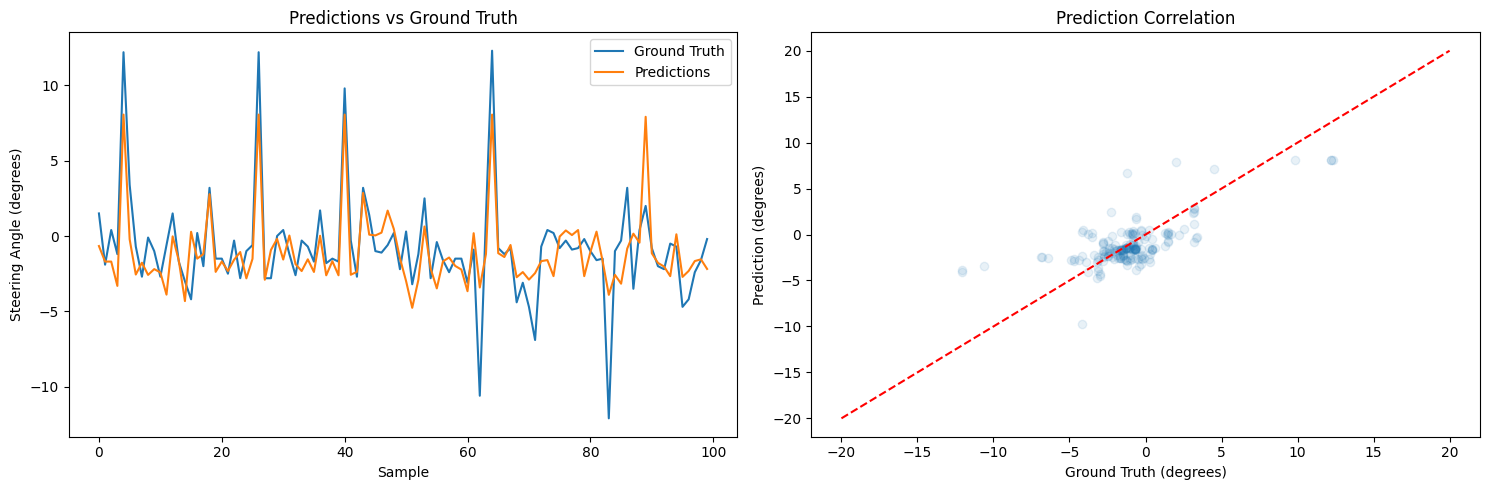


Visualizing some predictions...


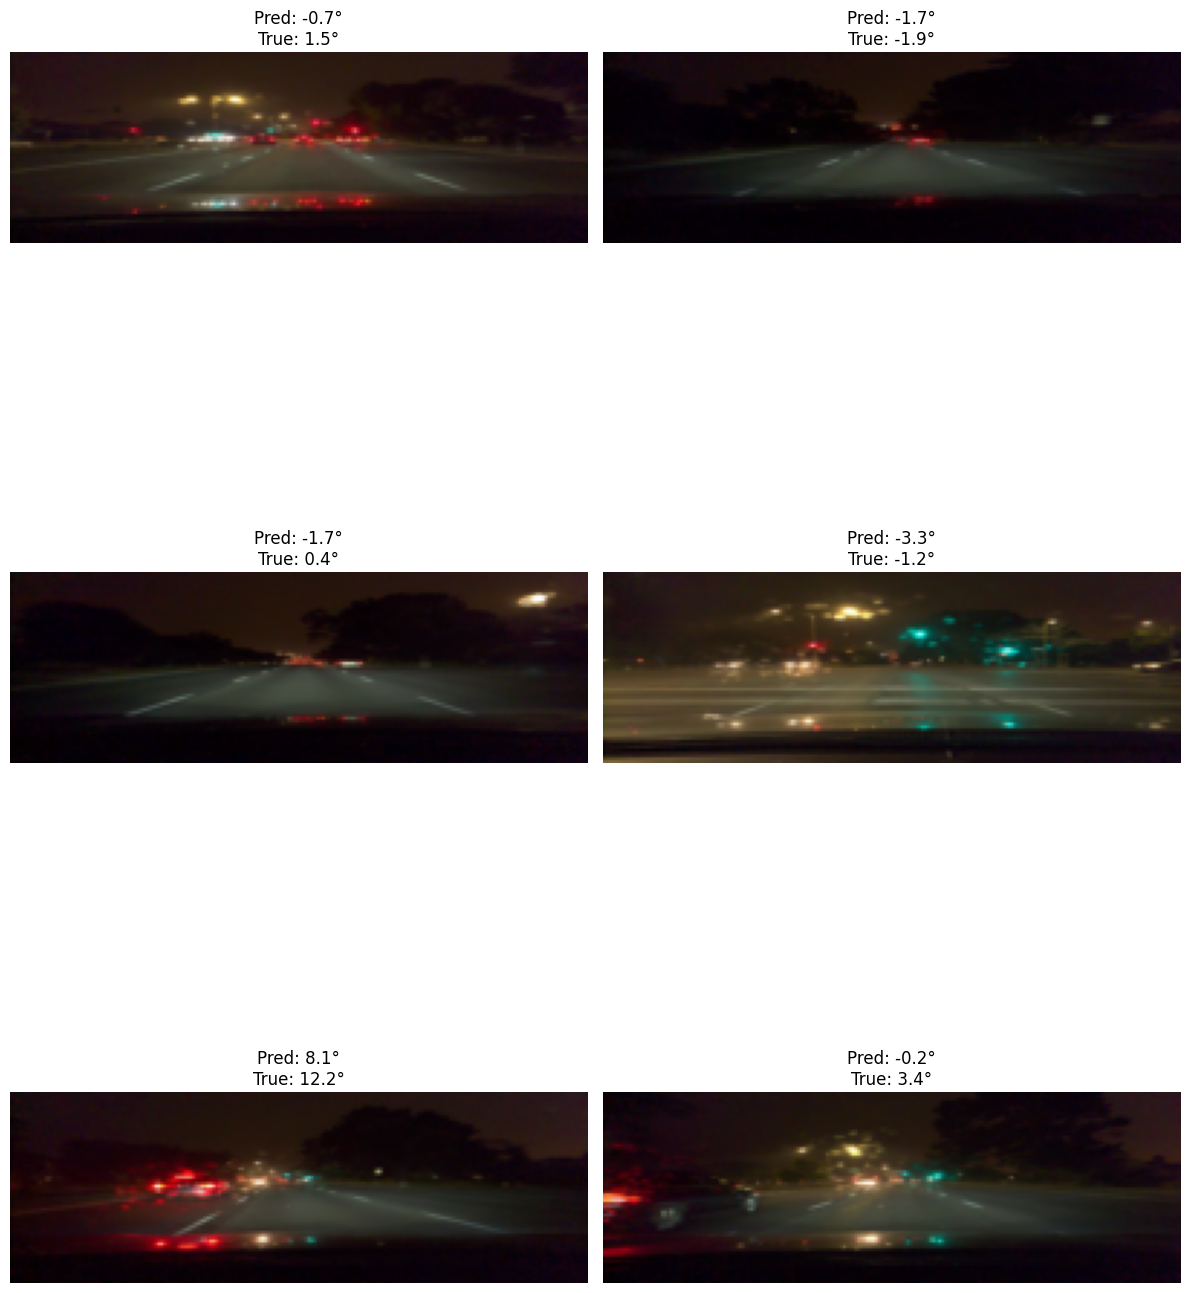

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np

# Initialize dataset
example_segment = 'data/comma2k19/extracted/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-03-57/3/'
dataset = DrivingDataset(
    csv_file='synced_steering_data.csv',
    video_path=example_segment + 'video.hevc'
)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# Initialize model, loss function, and optimizer
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,  # You can adjust this
    patience=5      # Early stopping patience
)

# Save the trained model
torch.save(model.state_dict(), 'steering_model.pth')
print("\nModel saved to 'steering_model.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

# Optional: Test on a single batch to visualize predictions
def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    
    # Get a single batch
    inputs, targets = next(iter(test_loader))
    inputs = inputs.to(device)
    
    with torch.no_grad():
        predictions = model(inputs)
    
    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()
    
    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]
        
        # Get the original image
        img = inputs[i].cpu().numpy().transpose(1, 2, 0)
        
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'Pred: {predictions[i][0]:.1f}°\nTrue: {targets[i]:.1f}°')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)